## Выделяем кусочек магнитограммы с помощью координат HMI

In [286]:
import numpy as np 
import os
import pandas as pd 
import time
import datetime
import drms
import urllib
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from datetime import timedelta
import json
import urllib, requests
import matplotlib.pyplot as plt
from sunpy.coordinates import frames
import warnings
warnings.filterwarnings("ignore")
import sunpy.wcs
import sunpy.map
import pickle
import astropy.units as u
from astropy.coordinates import SkyCoord
import re
import logging
%matplotlib inline

In [19]:
EMAIL = 'iknyazeva@gmail.com'
SAVE_PATH = 'dataset'


def check_dataset_directory():
    if not os.path.exists('dataset/fragments'):
        logging.warning('dataset folders not exist, create them')
        os.makedirs('dataset/fragments')
    
    return 'dataset'


## Sunspots data:

aggregated from   https://www.spaceweatherlive.com, which in turn aggregated from
ftp://ftp.swpc.noaa.gov/pub/warehouse/, location valid at 0 a.m

In [281]:
# sunspots = pickle.load(urllib.request.urlopen('https://raw.githubusercontent.com/iknyazeva/FitsProcessing/master/sunspot_1996_2017.pkl'))
# sunspots.tail(5)
sunspots.loc['2011-04-01']

number_of_ss size class location magn_class
date       region                                            
2011-04-01 11176            10  140   FSO   S16W51          B
           11178             1    0   AXX   S17W22          A
           11180             1   10   HRX   N24W13          A
           11181             1   10   HRX   S27W08          A
           11183            13  140   ESO   N15E14          B

In [282]:
sunspots.loc['2011-04-11']
dr = sunspots.loc['2011-04-01']
dr.index = dr.index.droplevel()
dr

# for row in sunspots['2011-04-01':].head(2).iterrows():
#     request_mfits_by_date(row[0][0], email=EMAIL, path_to_sace='dataset')
    

,number_of_ss,size,class,location,magn_class
region,,,,,
11176,10,140,FSO,S16W51,B
11178,1,0,AXX,S17W22,A
11180,1,10,HRX,N24W13,A
11181,1,10,HRX,S27W08,A
11183,13,140,ESO,N15E14,B


## Utility functions for cropping regions from fits by the date 

In [246]:
def find_box_coordinate(record, delta = 6):
    
    pattern = re.compile("[NS]\d{2}[EW]\d{2}")
    assert bool(pattern.match(record)), 'Pattern should be in the same format as N20E18'
    assert (abs(float(record[1:3])<=45)) and (abs(float(record[4:]))), 'Consider only regions between -45, +45 degree'
    if record[0]=='N':
        min_lat = float(record[1:3]) - delta
        max_lat = float(record[1:3]) + delta
    else:
        min_lat = -float(record[1:3]) - delta
        max_lat = -float(record[1:3]) + delta
    if record[2]=='W':
        min_lon = float(record[4:]) - delta
        max_lon = float(record[4:]) + delta
    else:
        min_lon = -float(record[4:]) - delta
        max_lon = -float(record[4:]) + delta  
    return min_lon, max_lon, min_lat, max_lat

def region_coord_list(datestr, sunspots_df=sunspots, limit_deg=45):
    """
    Function for working with sunspot_1996_2017.pkl dataframe, 
    which located here https://raw.githubusercontent.com/iknyazeva/FitsProcessing/master/sunspot_1996_2017.pkl,
    return list of tuples: (datestr, NOAA number, location)
    used in cropping
    
    args:
    datestr: string for date in the format used in dataframe '2001-04-30'
    sunspots_df: dataframe from file sunspot_1996_2017.pkl
    
    return: list of tuples
    """
    date_df = sunspots.loc[datestr]
    date_df.index = date_df.index.droplevel()
    rc_list = []
    for index, row in date_df.iterrows():
        if (abs(float(row.location[1:3])<=limit_deg)) and (abs(float(row.location[4:]))<=limit_deg):
            rc_list.append((pd.to_datetime(datestr, format='%Y-%m-%d'), index, row.location))
    return rc_list

def request_mfits_by_date(moment, email = EMAIL, path_to_sace = 'dataset'):
    """
    Function for request fits from JSOC database
    moment: pd.datetime object
    return: filepath to the magnetogram
    """

    c = drms.Client(email=email, verbose=True)
    str_for_query = 'hmi.m_720s'+ moment.strftime('[%Y.%m.%d_%H:%M:%S_TAI]{magnetogram}')
    print('Magnetogram:',str_for_query, ' will be downloaded .. ')
    r = c.export(str_for_query, method='url', protocol='fits')
    print(r)
    r.wait()
    print(r.request_url)
    filename ='hmi.m_720s.' +  moment.strftime('%Y%m%d_%H%M%S_TAI.magnetogram.fits')
    filepath = os.path.join('dataset', filename)

    print("Download data and save to path", filepath)
    r.download('dataset', verbose=True) 
    return filepath

def read_fits_to_map(filepath, plot_show=True):
    """
    read fits to sunpy object and plot in logariphmic scale
    return 
    mymap: sunpy object
    
    """
    
    plt.figure(figsize = (20,15))
    mymap = sunpy.map.Map(filepath)
    if plot_show:
        data = np.sign(mymap.data)*np.log1p(np.abs(mymap.data))
        plt.imshow(data, cmap = 'gray' )
        plt.colorbar()
    
    return mymap
 
def crop_fragment_by_record(rc_list_record, delta = 6, plot_full_disk=False):
    """
    Crop all fragments from magnetogram, based on information in rc_list_record
    It is supposed that full disk magnetogram already at the disk
    rc_list_record: tuple in format (datetime, NOAA number, location)
    return: submap and save fragments to subdirectory
    """
    
    filename ='hmi.m_720s.' +  rc_list_record[0].strftime('%Y%m%d_%H%M%S_TAI.1.magnetogram.fits')
    filepath = os.path.join('dataset', filename)
    
    if os.path.isfile(filepath):
    #assert os.path.isfile(filepath), 'There is not magnetogramm for this date'  
        print('Find magnetogram at disk ' + filepath)
        mymap = read_fits_to_map(filepath, plot_show=plot_full_disk)
    else:
        print('I need to download it from JSOC, it takes time...')
        request_mfits_by_date(rc_list_record[0])
    min_lon, max_lon, min_lat, max_lat = find_box_coordinate(record = rc_list_record[2], delta = delta)
    print('Bounding box coordinates: ', min_lon, max_lon, min_lat, max_lat)
    print(mymap.coordinate_frame)
    bl = sunpy.wcs.convert_hg_hpc(min_lon, min_lat, b0_deg=mymap.meta['crlt_obs'], l0_deg=158.92487, dsun_meters=mymap.dsun)
    tr = sunpy.wcs.convert_hg_hpc(max_lon, max_lat, b0_deg=mymap.meta['crlt_obs'], l0_deg=158.92487, dsun_meters=mymap.dsun)
    bottom_left = SkyCoord(bl[0]*u.arcsec, bl[1]*u.arcsec, frame="helioprojective")
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame="helioprojective")
#     bottom_left = SkyCoord(min_lon * u.deg, max_lon * u.deg, frame=mymap.coordinate_frame)
#     top_right = SkyCoord(min_lat * u.deg, max_lat * u.deg, frame=mymap.coordinate_frame)
    my_submap = mymap.submap(bottom_left, top_right)
    frag_filename ='hmi.m_720s.' +str(rc_list_record[1])+'.' +rc_list_record[0].strftime('%Y%m%d_%H%M%S_TAI.1.magnetogram.fits')
    
    if os.path.isfile(os.path.join('dataset', 'fragments', frag_filename)):
        print('Fragment already exists, if you want new version - delete previous')
    else:
        my_submap.save(os.path.join('dataset', 'fragments', frag_filename))
        print('Fragment write to '+os.path.join('dataset', 'fragments', frag_filename))
    
    return my_submap    

In [ ]:
sunpy.coordinates.(22*u.deg, 19*u.deg)

In [237]:
my_submap.carrington_longitude/u.deg

<Quantity 158.924866>

## Crop all available fragments at the specific date

In [284]:
rc_list = region_coord_list('2011-04-01')
rc_list

[(Timestamp('2011-04-01 00:00:00'), 11178, 'S17W22'),
 (Timestamp('2011-04-01 00:00:00'), 11180, 'N24W13'),
 (Timestamp('2011-04-01 00:00:00'), 11181, 'S27W08'),
 (Timestamp('2011-04-01 00:00:00'), 11183, 'N15E14')]

In [285]:
map = sunpy.map

Magnetogram: hmi.m_720s[2011.04.01_00:00:00_TAI]{magnetogram}  will be downloaded .. 
<ExportRequest id="JSOC_20190405_1030", status=2>
Export request pending. [id="JSOC_20190405_1030", status=2]
Waiting for 5 seconds...
http://jsoc.stanford.edu/SUM75/D1152115216/S00000
Download data and save to path dataset\hmi.m_720s.20110401_000000_TAI.magnetogram.fits
    record: hmi.M_720s[2011.04.01_00:00:00_TAI][1]
  filename: hmi.m_720s.20110401_000000_TAI.1.magnetogram.fits
  -> "dataset\hmi.m_720s.20110401_000000_TAI.1.magnetogram.fits.2"


'dataset\\hmi.m_720s.20110401_000000_TAI.magnetogram.fits'

Find magnetogram at disk dataset\hmi.m_720s.20110304_000000_TAI.1.magnetogram.fits
Bounding box coordinates:  -12.0 0.0 19.0 31.0
<Helioprojective Frame (obstime=2011-03-03 23:58:14.200000, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2011-03-03 23:58:14.200000): (lon, lat, radius) in (deg, deg, m)
    (0., -7.25208, 1.48301618e+11)>)>
Fragment already exists, if you want new version - delete previous


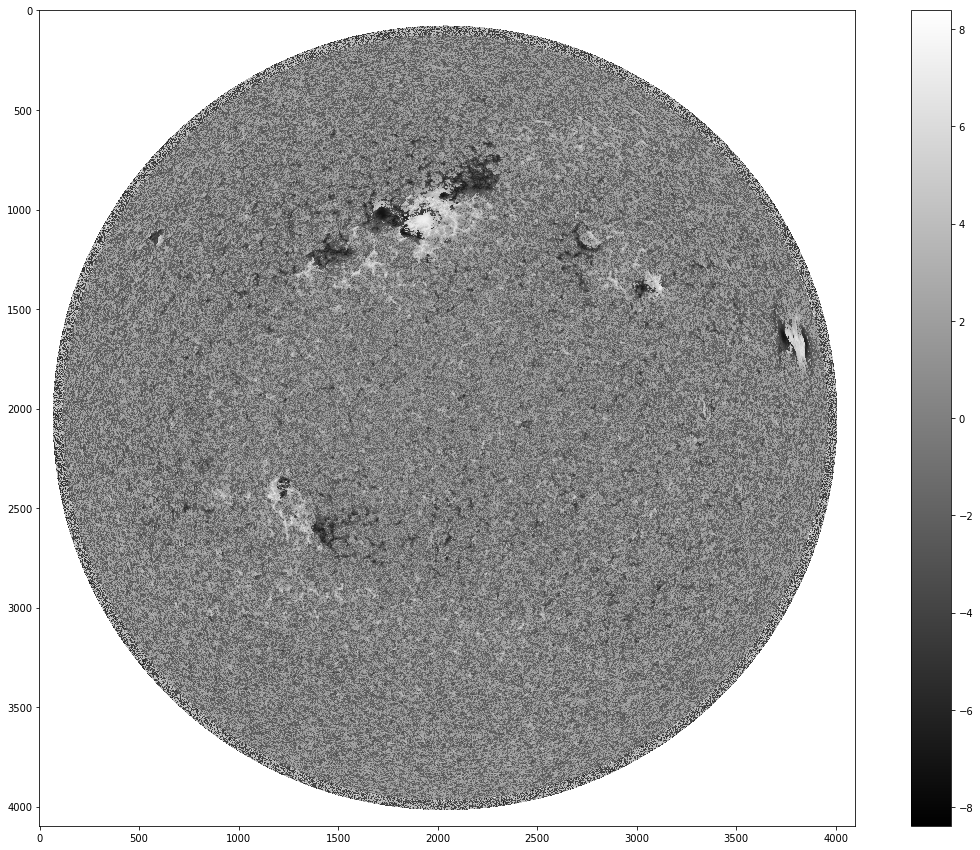

In [252]:
my_submap = crop_fragment_by_record(rc_list[0], plot_full_disk=True, delta=6)


SunPy Map
---------
Observatory:		 SDO
Instrument:		 HMI SIDE1
Detector:		 HMI
Measurement:		 magnetogram
Wavelength:		 6173.0
Observation Date:	 2011-03-03 23:58:14
Exposure Time:		 0.000000 s
Dimension:		 [306. 395.] pix
Coordinate System:	 helioprojective
Scale:			 [0.50428 0.50428] arcsec / pix
Reference Pixel:	 [-287.150146  790.593994] pix
Reference Coord:	 [0. 0.] arcsec
array([[ -5.5,  -0.5,  -5.5, ...,  -2.7,  -7.2,   3.2],
       [-12.2,  -8.6,  -2.8, ...,  -2.3,   2.3,  -2.8],
       [ -4.3,  -3.3,  -8.1, ...,  -3.9,  -5.8,   0.3],
       ...,
       [  2.8,   5. ,   1.2, ...,   5.2,  -2.4, -10. ],
       [  0.8,   3.4,   7.8, ...,   0.4,   2.1,  -4.7],
       [ 11.6,  12.1,   4.5, ...,   0. ,  -1.5,  -9.3]])

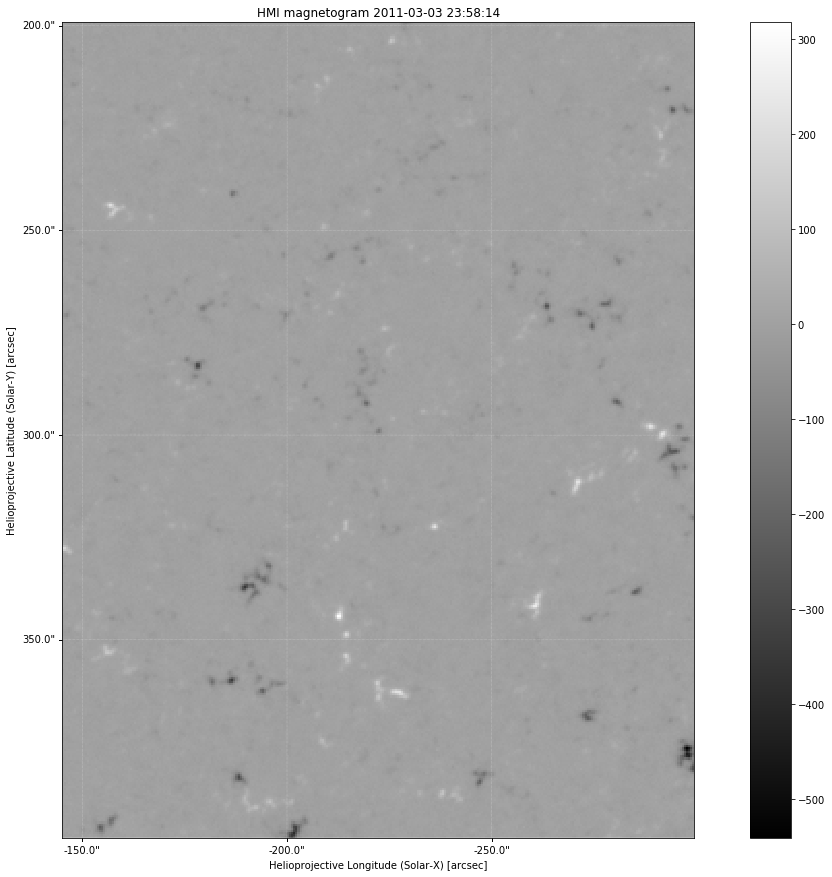

In [253]:
plt.figure(figsize=(20, 15))
my_submap.plot(cmap='gray')
plt.colorbar()
my_submap

In [249]:
my_submap = crop_fragment_by_record(rc_list[1])


Find magnetogram at disk dataset\hmi.m_720s.20110304_000000_TAI.1.magnetogram.fits
Bounding box coordinates:  -32.0 -20.0 -25.0 -13.0
<Helioprojective Frame (obstime=2011-03-03 23:58:14.200000, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2011-03-03 23:58:14.200000): (lon, lat, radius) in (deg, deg, m)
    (0., -7.25208, 1.48301618e+11)>)>
Fragment already exists, if you want new version - delete previous


<Figure size 1440x1080 with 0 Axes>

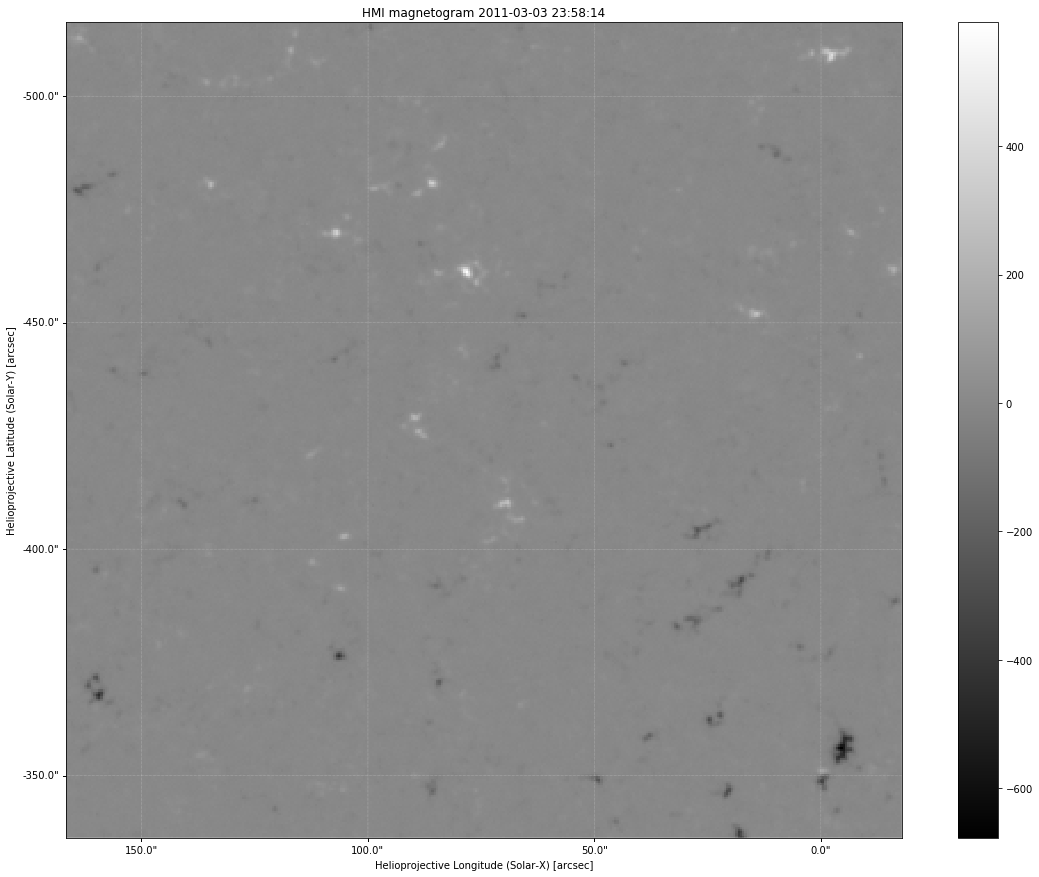

In [251]:
plt.figure(figsize=(20,15))
my_submap.plot(cmap='gray')
plt.colorbar()

<Figure size 1440x1080 with 0 Axes>

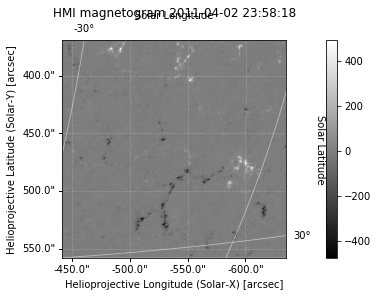

In [161]:
# sqrWidth = np.ceil(np.sqrt(my_submap.data.size[0]*my_submap.data.size[1])).astype(int)
# my_submap.data
PIL.Image.fromarray(my_submap.data)
im = PIL.Image.open('dataset/im.png')
np.ceil(np.sqrt(im.size[0]*im.size[1])).astype(int)
dimensions = u.Quantity([381, 381], u.pixel)
plt.figure(figsize=(20,15))
my_submap.peek(draw_limb=True, draw_grid=True)

In [278]:
len(sunspots.loc['2011-04-01':])

11203

In [287]:
map1 = sunpy.map.Map('dataset/hmi.m_720s.20110401_000000_TAI.1.magnetogram.fits')
map2 = sunpy.map.Map('dataset/hmi.m_720s.20110401_000000_TAI.1.magnetogram.fits.2')

In [288]:
region_coord_list('2011-04-01')

[(Timestamp('2011-04-01 00:00:00'), 11178, 'S17W22'),
 (Timestamp('2011-04-01 00:00:00'), 11180, 'N24W13'),
 (Timestamp('2011-04-01 00:00:00'), 11181, 'S27W08'),
 (Timestamp('2011-04-01 00:00:00'), 11183, 'N15E14')]

In [293]:
coor1 = SkyCoord(-17*u.deg, 22*u.deg, frame = map1.coordinate_frame)
coor1 = SkyCoord(-17*u.deg, 22*u.deg, frame = map2.coordinate_frame)

coor1

map1.world_to_pixel(coor1)

PixelPair(x=<Quantity 127046.36505573 pix>, y=<Quantity -170786.12744684 pix>)